<a href="https://colab.research.google.com/github/yukta2106/ML-ANN-Experiments/blob/main/ML_Experiment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================
# 1. Install requirements
# ==============================
!pip install pymc arviz --quiet

# ==============================
# 2. Imports
# ==============================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import aesara.tensor as at

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix

sns.set(style="whitegrid")

# ==============================
# 3. Load dataset (Breast Cancer)
# ==============================
data = load_breast_cancer()
X = data.data
y = data.target

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

# ==============================
# 4. Bayesian Logistic Regression
# ==============================
with pm.Model() as blr_model:
    # Priors
    alpha = pm.Normal("alpha", mu=0, sigma=5)
    beta = pm.Normal("beta", mu=0, sigma=5, shape=X_train.shape[1])

    # Linear model
    logits = alpha + at.dot(X_train, beta)

    # Likelihood
    y_obs = pm.Bernoulli("y_obs", logit_p=logits, observed=y_train)

    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=42, return_inferencedata=True)

# Posterior summary
print(az.summary(trace, var_names=["alpha","beta"], round_to=2))

# ==============================
# 5. Predictions (Bayesian LR)
# ==============================
posterior = trace.posterior
alpha_samples = posterior["alpha"].stack(sample=("chain","draw")).values
beta_samples = posterior["beta"].stack(sample=("chain","draw")).values

n_samples = alpha_samples.shape[0]
probs_ppc = np.zeros((n_samples, X_test.shape[0]))

for i in range(n_samples):
    logits = alpha_samples[i] + X_test.dot(beta_samples[i])
    probs = 1/(1+np.exp(-logits))
    probs_ppc[i] = probs

mean_probs = probs_ppc.mean(axis=0)
y_pred_bayes = (mean_probs >= 0.5).astype(int)

# Metrics
acc_bayes = accuracy_score(y_test, y_pred_bayes)
roc_auc_bayes = roc_auc_score(y_test, mean_probs)
print(f"Bayesian Logistic Regression → Accuracy: {acc_bayes:.3f}, AUC: {roc_auc_bayes:.3f}")

# ==============================
# 6. SVM Classification
# ==============================
svm = SVC(kernel="rbf", probability=True, random_state=42)
svm.fit(X_train, y_train)

probs_svm = svm.predict_proba(X_test)[:,1]
y_pred_svm = svm.predict(X_test)

acc_svm = accuracy_score(y_test, y_pred_svm)
roc_auc_svm = roc_auc_score(y_test, probs_svm)
print(f"SVM → Accuracy: {acc_svm:.3f}, AUC: {roc_auc_svm:.3f}")

# ==============================
# 7. ROC Curves
# ==============================
fpr_b, tpr_b, _ = roc_curve(y_test, mean_probs)
fpr_s, tpr_s, _ = roc_curve(y_test, probs_svm)

plt.figure(figsize=(6,5))
plt.plot(fpr_b, tpr_b, label=f"Bayesian LR (AUC={roc_auc_bayes:.3f})")
plt.plot(fpr_s, tpr_s, label=f"SVM (AUC={roc_auc_svm:.3f})")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

# ==============================
# 8. Confusion Matrices
# ==============================
fig, axs = plt.subplots(1,2, figsize=(10,4))
sns.heatmap(confusion_matrix(y_test,y_pred_bayes), annot=True, fmt="d", ax=axs[0], cmap="Blues")
axs[0].set_title("Bayesian Logistic Regression")

sns.heatmap(confusion_matrix(y_test,y_pred_svm), annot=True, fmt="d", ax=axs[1], cmap="Greens")
axs[1].set_title("SVM")

plt.show()

# ==============================
# 9. Posterior Distributions (for interpretation)
# ==============================
az.plot_posterior(trace, var_names=["alpha","beta"], hdi_prob=0.94, max_plots=20)
plt.show()


ModuleNotFoundError: No module named 'aesara'

In [ ]:
!pip install pymc arviz pytensor

In [ ]:
import pytensor.tensor as pt

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00


--- Bayesian Logistic Regression ---
Accuracy: 0.9547738693467337
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       148
           1       0.95      0.98      0.96       250

    accuracy                           0.95       398
   macro avg       0.96      0.95      0.95       398
weighted avg       0.95      0.95      0.95       398



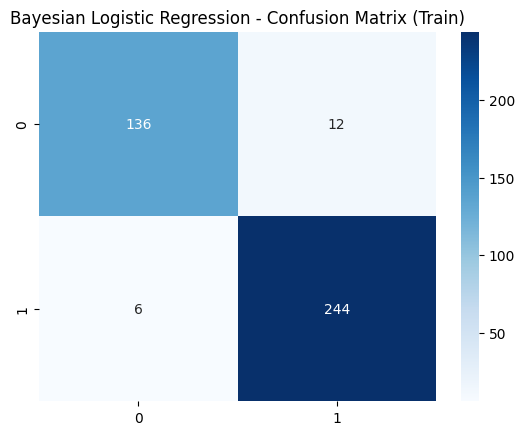


--- Support Vector Machine (SVM) ---
Accuracy: 0.9181286549707602
              precision    recall  f1-score   support

           0       0.86      0.94      0.90        64
           1       0.96      0.91      0.93       107

    accuracy                           0.92       171
   macro avg       0.91      0.92      0.91       171
weighted avg       0.92      0.92      0.92       171



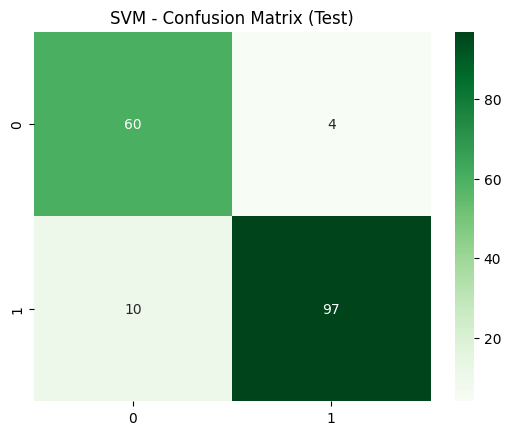

In [ ]:
# Install dependencies
!pip install pymc arviz pytensor scikit-learn matplotlib seaborn

# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pymc as pm
import arviz as az
import pytensor.tensor as pt

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Load dataset
data = load_breast_cancer()
X = data.data
y = data.target

# Use only first 10 features for simplicity
X = X[:, :10]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Standardize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# -----------------------
# Bayesian Logistic Regression
# -----------------------
with pm.Model() as logistic_model:
    # Priors
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X_train.shape[1])

    # Linear predictor
    mu = alpha + pm.math.dot(X_train, beta)
    p = pm.Deterministic("p", pm.math.sigmoid(mu))

    # Likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train)

    # Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=42)

# Posterior predictive check
with logistic_model:
    ppc = pm.sample_posterior_predictive(trace, random_seed=42)

# Predictions
y_pred_bayes = np.round(ppc.posterior_predictive["y_obs"].mean(dim=("chain", "draw")).values)

print("\n--- Bayesian Logistic Regression ---")
print("Accuracy:", accuracy_score(y_train, y_pred_bayes))
print(classification_report(y_train, y_pred_bayes))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_train, y_pred_bayes), annot=True, fmt="d", cmap="Blues")
plt.title("Bayesian Logistic Regression - Confusion Matrix (Train)")
plt.show()

# -----------------------
# Support Vector Machine (SVM)
# -----------------------
svm = SVC(kernel="linear", random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("\n--- Support Vector Machine (SVM) ---")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt="d", cmap="Greens")
plt.title("SVM - Confusion Matrix (Test)")
plt.show()
